# CIAA-ALL
Working with the CIAA-ALL dataset.
###### Nils Dyck, 12.05.2023

In [120]:
import pandas as pd

df = pd.read_csv('../data/cleaned/DATASET2.csv',sep=';') 
# df = pd.read_csv('../data/cleaned/DCFS-ALL.csv', sep=';')
df = df.loc[df['Year']<2022]
df_m = df.drop_duplicates(subset='Title')

In [121]:
authors = df['Author-URL'].to_list()
everyone = authors
len(set(authors))

863

In [122]:
df_m.shape

(40459, 10)

Is there a 'NONE'-problem within the titles?

In [123]:
df_none = df.loc[df['Title']=='None']
df_none.to_csv('../data/cleaned/CIAA-ALL_None.csv', sep=';',index=False)

In [124]:
authors = df['Author-URL'].drop_duplicates().to_list()
print(len(authors))

863


As there are more authors in the CIAA-ALL dataset than in the CIAA-CIAA dataset, we need to compare both datasets and find the overhanging authors.

In [125]:
ciaa = pd.read_csv('../data/cleaned/CIAA-CIAA_m2.csv', sep=';')
# ciaa = pd.read_csv('../data/cleaned/DCFS-DCFS_m2.csv', sep=';')
ciaa = ciaa.loc[ciaa['Year']<2022]
ciaa_authors = ciaa['Author'].drop_duplicates().to_list()
len(ciaa_authors)

839

In [126]:
missing_in_ciaa = [author for author in authors if author not in ciaa_authors]
missing_in_ciaa

['https://dblp.uni-trier.de/pid/228/6835.html',
 'https://dblp.uni-trier.de/pid/75/4426.html',
 'https://dblp.uni-trier.de/pid/11/4210.html',
 'https://dblp.uni-trier.de/pid/04/704.html',
 'https://dblp.uni-trier.de/pid/265/6260.html',
 'https://dblp.uni-trier.de/pid/181/2007-1.html',
 'https://dblp.uni-trier.de/pid/09/4711.html',
 'https://dblp.uni-trier.de/pid/70/6536-3.html',
 'https://dblp.uni-trier.de/pid/v/HeikoVogler.html',
 'https://dblp.uni-trier.de/pid/16/1677.html',
 'https://dblp.uni-trier.de/pid/191/3141-1.html',
 'https://dblp.uni-trier.de/pid/84/635.html',
 'https://dblp.uni-trier.de/pid/27/4119.html',
 'https://dblp.uni-trier.de/pid/212/4580.html',
 'https://dblp.uni-trier.de/pid/20/2344.html',
 'https://dblp.uni-trier.de/pid/22/5692.html',
 'https://dblp.uni-trier.de/pid/292/7939.html',
 'https://dblp.uni-trier.de/pid/259/0271.html',
 'https://dblp.uni-trier.de/pid/c/ArnaudCarayol.html',
 'https://dblp.uni-trier.de/pid/263/2917.html',
 'https://dblp.uni-trier.de/pid/09

Deleting the authors who only published at 2022 to CIAA.

In [127]:
df = df.loc[~(df['Author-URL'].isin(missing_in_ciaa))]
df_m = df.drop_duplicates(subset='Title')
authors = df['Author-URL'].drop_duplicates().to_list()
titles = df.drop_duplicates(subset='Title')
df_m.shape

(39829, 10)

### Mean number of authors and power law

In [128]:
authors = df['Author-URL'].to_list()
print(len(set(authors)))
paper_author_list = [0 for i in range(721)]
papers_per_author = []

for author in set(authors):
    res = authors.count(author)
    papers_per_author.append(res)
    paper_author_list[res] += 1

mean = sum(papers_per_author)/len(papers_per_author)
mean

839


65.51489868891538

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


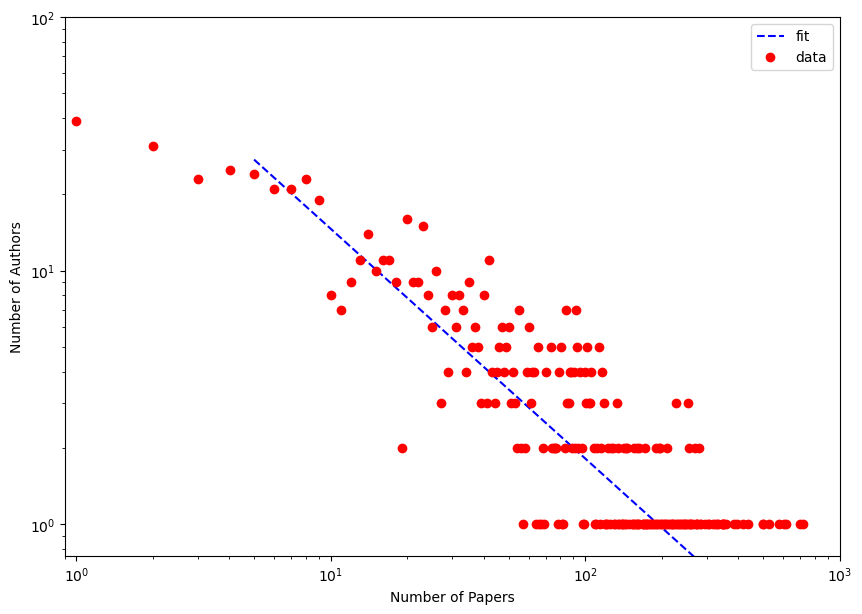

In [129]:
import matplotlib.pyplot as plt, numpy as np, math
from scipy.optimize import curve_fit

plt.figure(figsize=(10,7))

# Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Initiate data
x = np.linspace(0,721,721)
y = paper_author_list
x_fit = np.linspace(5,671,666)
y_fit = paper_author_list[5:-50]

# Fit the power-law function to the data
popt, pcov = curve_fit(power_law, x_fit, y_fit)

# Plot the fitted power-law curve
y_fit = power_law(x_fit, *popt)
plt.loglog(x_fit, y_fit, '--b', label='fit')

# Plot the data on a log-log scale
plt.loglog(x, y, 'or', label='data')

# Add labels and legend
plt.xlabel('Number of Papers')
plt.ylabel('Number of Authors')
plt.legend()
plt.axis((0.9e0,1e3,0.75e0,1e2))

plt.show()

In [130]:
a = popt[0]
b = popt[1]
print(a)
print(b)

117.83708636972621
-0.9055619123069555


Mean number of authors per paper

In [131]:
co_author_urls = titles['Co-Author-URLs'].to_list()
no_authors = []
for entries in co_author_urls:
    if entries == '[]': no_authors.append(1)
    else:
        entries = entries.replace('[','').replace(']','').replace('"','').replace("'",'') 
        entries = entries.split(', ')
        no_authors.append(len(entries)+1)
sum(no_authors)/len(no_authors)

3.1906650932737453

## Creating the network

In [132]:
import networkx as nx

G = nx.Graph()

authors = df['Author-URL'].to_list()
co_authors = df['Co-Author-URLs'].to_list()

G.add_nodes_from(set(authors))

for i in range(len(authors)):    
    entries = co_authors[i].replace('[','').replace(']','').replace('"','').replace("'",'') 
    if entries != '':
        entries = entries.split(', ')
        for entry in entries:
            G.add_edge(authors[i],entry)
G.number_of_nodes()

with open('../../CIAA-ALL'+str(i)+'.txt', 'a') as f:
        for edge in G.edges():
            f.write(edge[0]+' '+edge[1]+'\n')

In [133]:
components = nx.connected_components(G)
giant_component = sorted(components, key=len, reverse=True)[0]
len(giant_component)

25288

In [134]:
G.number_of_nodes()

25425

In [135]:
degrees = dict(nx.degree(G))

degrees = {key: value for key,value in degrees.items() if key in authors}

average_degree = sum(degrees.values()) / len(degrees)

print("Average Degree:", average_degree)

Average Degree: 45.106078665077476


In [136]:
nx.average_clustering(G)

0.13071797384661413

In [137]:
G = G.subgraph(set(authors))
G.number_of_nodes()

839

In [138]:
components = nx.connected_components(G)
giant_component = sorted(components, key=len, reverse=True)[0]
print('size of giant component: '+str(len(giant_component)))
print('relative size of giant component: '+str(len(giant_component)/G.number_of_nodes()))

size of giant component: 709
relative size of giant component: 0.8450536352800954


In [139]:
components = nx.connected_components(G)
giant_component = sorted(components, key=len, reverse=True)[1]
print('size of second component: '+str(len(giant_component)))
print('relative size of second component: '+str(len(giant_component)/G.number_of_nodes()))

size of second component: 8
relative size of second component: 0.009535160905840286


In [140]:
components =  nx.connected_components(G)
giant_component_graph = G.subgraph(sorted(components, key=len, reverse=True)[0])
print('mean distance: '+str(nx.average_shortest_path_length(giant_component_graph)))
print('maximum distance: '+str(max(nx.eccentricity(giant_component_graph).values())))
print('clustering coefficient: '+str(nx.average_clustering(G)))

mean distance: 4.688990620990812
maximum distance: 12
clustering coefficient: 0.489689987216481


In [142]:
ciaa_author_dict = pd.read_csv('../data/processed/CIAA-authors.csv', sep=';')
dcfs_author_dict = pd.read_csv('../data/processed/DCFS-authors.csv', sep=';')

ciaa_author_dict = {ciaa_author_dict['URL'].to_list()[i]: ciaa_author_dict['Name'].to_list()[i] for i in range(len(ciaa_author_dict['URL'].to_list()))}
dcfs_author_dict = {dcfs_author_dict['URL'].to_list()[i]: dcfs_author_dict['Name'].to_list()[i] for i in range(len(dcfs_author_dict['URL'].to_list()))}

def get_Name(url, venue):
    if venue == 'CIAA': return ciaa_author_dict[url]
    elif venue == 'DCFS': return dcfs_author_dict[url]
    else: return 'ERROR'
# def get_name(url):
#     name = df.loc[df['Author-URL']==url]
#     name = name['Author'].to_list()
#     name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')
#     return name

paper_ranking = {}
fractional_ranking = {}
co_worker_ranking = {}
collaboration_weight = {}
collaboration_weight_urls = {}
for author in authors:
    papers = everyone.count(author)
    name = get_Name(author,'CIAA')
    # name = df.loc[df['Author-URL']==author]
    # name = name['Author'].to_list()
    # name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')    
    paper_ranking[name] = papers
    papers = df.loc[df['Author-URL']==author]
    co_authors = papers['Co-Author-URLs'].to_list()
    fraction = 0
    co_workers = []
    for l in co_authors:
        l = l.replace('[','').replace(']','').replace('"','').replace("'",'') 
        l = l.split(', ')
        # for i in l:
        #     if i != '':
        #         if collaboration_weight.get((name,get_Name(i,'CIAA'))):
        #             collaboration_weight[(name,get_Name(i,'CIAA'))] += 1
        #             collaboration_weight_urls[(author,i)] += 1
        #         else:
        #             collaboration_weight[(name,get_Name(i,'CIAA'))] = 1
        #             collaboration_weight_urls[(author,i)] = 1
        fraction += (1/(len(l)+1))
        co_workers += l
    co_workers = set(co_workers)
    co_workers = [entry for entry in co_workers if entry != '']
    co_worker_ranking[name] = len(co_workers)
    fractional_ranking[name] = fraction

paper_ranking_sorted = dict(sorted(paper_ranking.items(), key=lambda item: item[1], reverse=True))
fractional_ranking_sorted = dict(sorted(fractional_ranking.items(), key=lambda item: item[1], reverse=True))
co_worker_ranking_sorted = dict(sorted(co_worker_ranking.items(), key=lambda item: item[1], reverse=True))
collaboration_weight_sorted = dict(sorted(collaboration_weight.items(), key=lambda item: item[1], reverse=True))

#delete duplicates in collaboration weight
keys = list(collaboration_weight_sorted.keys())
control = set(keys)
for key in keys:
    if set(key) in control:
        del collaboration_weight_sorted[(key[1],key[0])]
        control.remove(set(key))

top10_papers = list(paper_ranking_sorted.items())[:10]
top10_fractional = list(fractional_ranking_sorted.items())[:10]
top10_co_workers = list(co_worker_ranking_sorted.items())[:10]
top10_collaboration_weights = list(collaboration_weight_sorted.items())[:10]

In [143]:
from tabulate import tabulate

headers = ['number of papers']
table1 = tabulate(top10_papers, headers, tablefmt='latex')
print(table1)

headers = ['fractional no. of papers']
table2 = tabulate(top10_fractional, headers, tablefmt='latex')
print(table2)

headers = ['number of co-workers']
table3 = tabulate(top10_co_workers, headers, tablefmt='latex')
print(table3)


\begin{tabular}{lr}
\hline
                       &   number of papers \\
\hline
 Moshe Y. Vardi        &                720 \\
 Alois C. Knoll        &                700 \\
 Grzegorz Rozenberg    &                614 \\
 Václav Snásel         &                604 \\
 Gonzalo Navarro       &                578 \\
 Thomas A. Henzinger   &                527 \\
 B. Sundar Rajan       &                500 \\
 Kim Guldstrand Larsen &                499 \\
 Axel Legay            &                437 \\
 Oscar H. Ibarra       &                415 \\
\hline
\end{tabular}
\begin{tabular}{lr}
\hline
                     &   fractional no. of papers \\
\hline
 Moshe Y. Vardi      &                    271.354 \\
 Grzegorz Rozenberg  &                    239.629 \\
 B. Sundar Rajan     &                    221.617 \\
 Gonzalo Navarro     &                    208.554 \\
 Alois C. Knoll      &                    177.343 \\
 Thomas A. Henzinger &                    171.479 \\
 Oscar H. Ibarra     & 